# Penndulum Model Codes

## Dependencies

In [1]:
import os
import shutil
import random; random.seed(42)

import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import torch
from torch import nn
#import tensorflow as tf # tensorflow-gpu==2.0.0
#from tensorflow.python.client import device_lib 
#print(device_lib.list_local_devices())
#import cv2

## Directories:

In [2]:
# training data
train_dir = '/raid/cs152/zxaa2018/penndulum/train_and_test_split/dpc_dataset_traintest_4_200_csv/train'
train_dir_video = '/raid/cs152/zxaa2018/penndulum//train_and_test_split/dpc_dataset_traintest_4_200_h264/train'

# test data
test_inputs_dir = '/raid/cs152/zxaa2018/penndulum/train_and_test_split/dpc_dataset_traintest_4_200_csv/test_inputs/'
test_targets_dir = '/raid/cs152/zxaa2018/penndulum/train_and_test_split/dpc_dataset_traintest_4_200_csv/test_targets/'
test_targets_video = '/raid/cs152/zxaa2018/penndulum/train_and_test_split/dpc_dataset_traintest_4_200_h264/test_targets/'

# validation data
validation_inputs_dir = '/raid/cs152/zxaa2018/penndulum/train_and_test_split/dpc_dataset_traintest_4_200_csv/validation_inputs/'
validation_targets_dir = '/raid/cs152/zxaa2018/penndulum/rain_and_test_split/dpc_dataset_traintest_4_200_csv/validation_targets/'
validation_targets_video = '/raid/cs152/zxaa2018/penndulum/train_and_test_split/dpc_dataset_traintest_4_200_h264/validation_targets/'

## Functions and Class Definitions

### Data Transformation Functions

In [3]:
# some constants
DEFAULT_X_RED, DEFAULT_Y_RED = (240, 232)

PIXEL_DISTANCE_GREEN_TO_RED = 118 # approx. value | calculated with the Pythagorean theorem and averaged: np.sqrt((y_green-y_red)**2 + (x_green-x_red)**2)
PIXEL_DISTANCE_BLUE_TO_GREEN = 90 # approx. value | calculated with the Pythagorean theorem and averaged: np.sqrt((y_blue-y_green)**2 + (x_blue-x_green)**2)

def raw_to_pixel(l):
    '''Convert the raw coordinates to pixel coordinates.'''
    assert isinstance(l, list)
    return [x/5 for x in l]


def pixel_to_raw(l):
    '''Convert the pixel coordinates to raw coordinates.'''
    assert isinstance(l, list)
    return [x*5 for x in l]


def raw_cartesian_to_polar_angles(l):
    '''Convert the cartesian coordinates to polar coordinates.'''
    assert isinstance(l, list)
    x_red, y_red, x_green, y_green, x_blue, y_blue = raw_to_pixel(l)

    angle_green_red = np.arctan((y_green-y_red)/(x_green-x_red+0.001))
    angle_blue_green = np.arctan((y_blue-y_green)/(x_blue-x_green+0.001))
    
    return [np.sin(angle_green_red), np.cos(angle_green_red), np.sin(angle_blue_green), np.cos(angle_blue_green)]

def polar_angles_to_raw_cartesian(l):
    '''Convert the polar coordinates back to cartesian coordinates.'''
    assert isinstance(l, list)
    sin_angle_green_red, cos_angle_green_red, sin_angle_blue_green, cos_angle_blue_green = l
    
    y_green = PIXEL_DISTANCE_GREEN_TO_RED * sin_angle_green_red + DEFAULT_Y_RED
    x_green = PIXEL_DISTANCE_GREEN_TO_RED * cos_angle_green_red + DEFAULT_X_RED

    y_blue = PIXEL_DISTANCE_BLUE_TO_GREEN * sin_angle_blue_green + y_green
    x_blue = PIXEL_DISTANCE_BLUE_TO_GREEN * cos_angle_blue_green + x_green
    
    return pixel_to_raw([DEFAULT_X_RED, DEFAULT_Y_RED, x_green, y_green, x_blue, y_blue])

### Data reading functions

Parsing training data:
training data x-y matching is like this:
x: a list of 4 frames
y: the frame that follows

In [4]:
def parse_training_annotations(csv_file):
    '''Parse the training annotations from a CSV file.'''
    X_data = []
    y_data = []
    f = pd.read_csv(csv_file, header=None, delim_whitespace=True, engine='python')
    temp = []
    for i, row in f.iterrows():
        if len(temp) < 4:
            # convert the cartesian pixel coordinates to polar coordinates
            temp.append(raw_cartesian_to_polar_angles(row.to_list()))
        else:
            # the output frame
            # convert the cartesian pixel coordinates to polar coordinates
            next_frame = raw_cartesian_to_polar_angles(row.to_list())

            # save
            X_data.append(temp.copy())
            y_data.append(next_frame.copy())

            # add output frame to the inputs and remove the first
            temp.pop(0)
            temp.append(next_frame)
    return X_data, y_data

In [5]:
def parse_testing_annotations(csv_file_X,csv_file_Y):
    '''
    Parse the testing annotations from a CSV file.
    Return a x-y pair
    '''
    X_data = [] #a list containing 4 frames
    y_data = [] #a list containing 200 frames
    # load X file
    f = pd.read_csv(csv_file_X, header=None, delim_whitespace=True, engine='python')
    for i, row in f.iterrows():
        X_data.append(raw_cartesian_to_polar_angles(row.to_list()))
    f = pd.read_csv(csv_file_Y, header=None, delim_whitespace=True, engine='python')
    for i, row in f.iterrows():
        y_data.append(raw_cartesian_to_polar_angles(row.to_list()))
        #print(row)

    return X_data, y_data

### Dataset Definition

In [6]:
class DoublePendulumDataset(torch.utils.data.Dataset):
    def __init__(self,X_list,y_list):
        self.sample_list = list(zip(X_list, y_list))
    
    def __getitem__(self,index):
        X_sample,y_sample = self.sample_list[index]
        return torch.from_numpy(np.array(X_sample)).float(),torch.from_numpy(np.array(y_sample)).float()
    
    def __len__(self):
        return len(self.sample_list)

### Model Definition

In [7]:
class LSTMModel(nn.Module):
    def __init__(self):
        # We want a model of 4 layer LSTM with 32 features output, and a dense layer to form the 4 feature output.
        super(LSTMModel, self).__init__()

        # Defining some parameters
        #self.hidden_size = 32
        #self.n_layers = 4

        #Defining the layers
        # LSTM layer
        self.lstm1 = nn.LSTM(input_size = 4, hidden_size = 32, num_layers = 1, batch_first = True)
        #self.lstm2 = nn.LSTM(input_size = 32, hidden_size = 32, num_layers = 1, batch_first = True)
        #self.lstm3 = nn.LSTM(input_size = 32, hidden_size = 32, num_layers = 1, batch_first = True)
        # Fully connected layer
        self.fc = nn.Linear(32, 4)
    
    def forward(self, x):
        out3, _= self.lstm1(x) # (h0.detach(), c0.detach())
        #out2, _= self.lstm2(out1)
        #out3, _= self.lstm3(out2)
        out3 = out3[:, -1, :]
        out = self.fc(out3)
        return out

Data Visualization Functions

In [8]:
def plot_trajectory_from_tensor(coords: torch.Tensor):
    blue_x = coords.index_select(1,torch.tensor([4])).numpy()
    blue_y = coords.index_select(1,torch.tensor([5])).numpy()
    plt.scatter(blue_x,blue_y)

## Training, testing and analysis Codes

### Loading Training Data

In [9]:
BATCH_SIZE = 1000

# load in all separate files
X_train = []
y_train = []
for filename in tqdm([x for x in os.listdir(train_dir) if not x.startswith('.')]):
    # load in a file
    X_data, y_data = parse_training_annotations(os.path.join(train_dir, filename))

    X_train = X_train + X_data
    y_train = y_train + y_data
trainDataSet = DoublePendulumDataset(X_train,y_train)
trainDataLoader = torch.utils.data.DataLoader(trainDataSet,batch_size=BATCH_SIZE)


100%|██████████| 40/40 [00:36<00:00,  1.11it/s]


In [25]:
temp_seq = y_train[300:400]
temp_seq = [polar_angles_to_raw_cartesian(y)[4:] for y in temp_seq]

Text(0, 0.5, '$P(t)$')

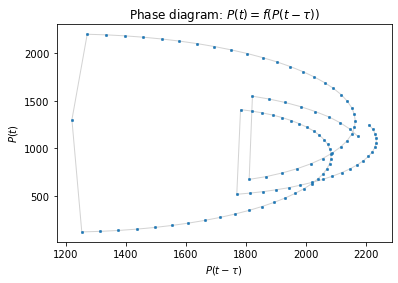

In [26]:
plt_x = [y[0] for y in temp_seq]
plt_y = [y[1] for y in temp_seq]
plt.title(f"Phase diagram: $P(t) = f(P(t-\\tau))$")
plt.plot(plt_x, plt_y, lw=1,color="lightgrey", zorder=0)
plt.scatter(plt_x, plt_y,lw=0.5, cmap="viridis", s=6)
plt.xlabel("$P(t-\\tau)$")
plt.ylabel("$P(t)$")

### Hyperparameter and Model instantiate

In [10]:
# Instantiate the model with hyperparameters
model = LSTMModel()
model.train()

# Define hyperparameters
n_epochs = 5
lr=0.001

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### Training

In [73]:
print('Training Start')
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainDataLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

Training Start
[1,   100] loss: 0.235
[1,   200] loss: 0.062
[1,   300] loss: 0.043
[2,   100] loss: 0.032
[2,   200] loss: 0.022
[2,   300] loss: 0.020
[3,   100] loss: 0.022
[3,   200] loss: 0.018
[3,   300] loss: 0.018
[4,   100] loss: 0.020
[4,   200] loss: 0.017
[4,   300] loss: 0.016
[5,   100] loss: 0.019
[5,   200] loss: 0.016
[5,   300] loss: 0.016
Finished Training


### Testing Data Loading

In [74]:
# load in all separate files
X_test = []
y_test = []
isPrint = True
#for filename in tqdm([x for x in os.listdir(test_inputs_dir) if not x.startswith('.')]):
for i in range(60):
    # load in a file
    X_data, y_data = parse_testing_annotations(test_inputs_dir + str(i)+'.csv',test_targets_dir + str(i)+'.csv')
    X_test.append(X_data)
    y_test.append(y_data)
testDataSet = DoublePendulumDataset(X_test,y_test)
testDataLoader = torch.utils.data.DataLoader(testDataSet,batch_size=1) # Do we need the data loader here?

In [75]:
def predict(model: LSTMModel, testDataSet, index):
    '''
    Use the testing file on coordinates to get a tensor of the 200 outputs.
    '''
    result = torch.empty(1,1,4).float()
    X_frames = testDataSet[index][0][None,:,:]
    for i in range(200):
        output_frame = model(X_frames).detach()
        result = torch.cat((result,output_frame[None,:,:]),1) if i != 0 else output_frame[None,:,:]
        X_frames = X_frames.index_select(1,torch.tensor([1,2,3]))
        X_frames = torch.cat((X_frames,output_frame[None,:,:]),1)
    return result.squeeze()

In [76]:
def polar_angles_to_raw_cartesian_tensor(t):
    '''Convert the polar coordinates back to cartesian coordinates.'''
    assert isinstance(t, torch.Tensor)

    sin_angle_green_red = t.index_select(1,torch.tensor([0]))
    cos_angle_green_red = t.index_select(1,torch.tensor([1]))
    sin_angle_blue_green = t.index_select(1,torch.tensor([2]))
    cos_angle_blue_green = t.index_select(1,torch.tensor([3]))
    
    y_green = PIXEL_DISTANCE_GREEN_TO_RED * sin_angle_green_red + DEFAULT_Y_RED
    x_green = PIXEL_DISTANCE_GREEN_TO_RED * cos_angle_green_red + DEFAULT_X_RED

    y_blue = PIXEL_DISTANCE_BLUE_TO_GREEN * sin_angle_blue_green + y_green
    x_blue = PIXEL_DISTANCE_BLUE_TO_GREEN * cos_angle_blue_green + x_green

    x_red = torch.full_like(y_green,DEFAULT_X_RED)
    y_red = torch.full_like(y_green,DEFAULT_Y_RED)

    result = torch.cat((x_red,y_red,x_green, y_green, x_blue, y_blue),1) * 5
    
    return result

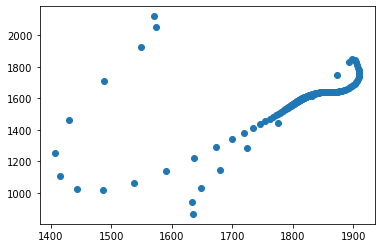

In [87]:
output = polar_angles_to_raw_cartesian_tensor(predict(model,testDataSet,8))
plot_trajectory_from_tensor(output)

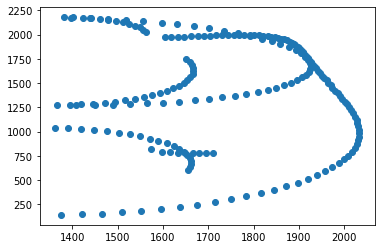

In [86]:
plot_trajectory_from_tensor(polar_angles_to_raw_cartesian_tensor(testDataSet[8][1]))

In [79]:
trainDataSet[5]

(tensor([[-0.7346,  0.6785, -0.0665,  0.9978],
         [-0.7618,  0.6478, -0.1377,  0.9905],
         [-0.7861,  0.6180, -0.2038,  0.9790],
         [-0.8111,  0.5849, -0.2659,  0.9640]]),
 tensor([-0.8344,  0.5512, -0.3295,  0.9442]))

In [80]:
trainDataSet[0]

(tensor([[-0.5921,  0.8059,  0.2808,  0.9598],
         [-0.6235,  0.7819,  0.2089,  0.9779],
         [-0.6508,  0.7593,  0.1396,  0.9902],
         [-0.6785,  0.7346,  0.0709,  0.9975]]),
 tensor([-0.7063,  0.7080,  0.0000,  1.0000]))

In [81]:
trainDataSet[1]

(tensor([[-0.6235,  0.7819,  0.2089,  0.9779],
         [-0.6508,  0.7593,  0.1396,  0.9902],
         [-0.6785,  0.7346,  0.0709,  0.9975],
         [-0.7063,  0.7080,  0.0000,  1.0000]]),
 tensor([-0.7346,  0.6785, -0.0665,  0.9978]))